# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import pandas as pd
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
from PIL import Image


### Change directory

In [3]:
from google.colab import drive
drive.mount('/drive/')
import os
os.chdir('/drive/My Drive/Data/Residency9/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [19]:
ls -1

daily-minimum-temperatures-in-me.csv
images/
images_racoon.rar
train_labels.csv


### Load the training data from train.csv file

In [0]:
train = pd.read_csv("train_labels.csv")

In [39]:
train.sample(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
165,raccoon-65.jpg,480,360,raccoon,123,27,338,284
161,raccoon-109.jpg,192,259,raccoon,9,1,177,252
14,raccoon-91.jpg,236,314,raccoon,22,14,216,308
82,raccoon-34.jpg,259,194,raccoon,1,2,227,194
57,raccoon-187.jpg,362,357,raccoon,161,112,292,276
112,raccoon-133.jpg,490,640,raccoon,8,6,476,631
79,raccoon-85.jpg,620,465,raccoon,236,87,598,429
120,raccoon-103.jpg,480,640,raccoon,92,54,460,545
80,raccoon-49.jpg,640,395,raccoon,162,36,611,395
96,raccoon-24.jpg,268,188,raccoon,139,77,202,145


### Print the shape of the train dataset

In [8]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [28]:
train.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [0]:
paths = []
coords = np.zeros((173,4))
for col, row in train.iterrows():
  path ='images/'+ row['filename']
  image_width = int(row['width'])
  image_height= int(row['height'])
  x0= int(row['xmin'])
  y0= int(row['ymin'])
  x1= int(row['xmax'])
  y1= int(row['ymax'])
  coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
  coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
  coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
  coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
  coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
  paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
for layer in model.layers:
    layer.trainable = False

x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [81]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])
model.fit(batch_images,coords,epochs=10,batch_size = 32,verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
173/173 [==============================] - 7s 42ms/step - loss: 3093.8108 - IoU: 0.0613
Epoch 2/10
173/173 [==============================] - 5s 29ms/step - loss: 756.7949 - IoU: 0.3942
Epoch 3/10
173/173 [==============================] - 5s 29ms/step - loss: 632.8912 - IoU: 0.5326
Epoch 4/10
173/173 [==============================] - 5s 29ms/step - loss: 631.2159 - IoU: 0.5224
Epoch 5/10
173/173 [==============================] - 5s 29ms/step - loss: 370.9975 - IoU: 0.5870
Epoch 6/10
173/173 [==============================] - 5s 28ms/step - loss: 270.1574 - IoU: 0.5883
Epoch 7/10
173/173 [==============================] - 5s 29ms/step - loss: 255.2936 - IoU: 0.6017
Epoch 8/10
173/173 [==============================] - 5s 28ms/step - loss: 205.1583 - IoU: 0.6443
Epoch 9/10
173/173 [==============================] - 5s 29ms/step - loss: 168.1050 - IoU: 0.6964
Epoch 10/10
173/173 [==============================] - 5s 29ms/step -

### Pick a test image from the given data

In [0]:
import cv2
filename = './images/raccoon-24.jpg'
unscaled = cv2.imread(filename) 


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0]

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)
x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

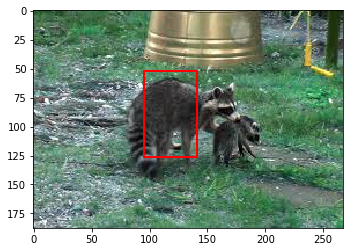

In [93]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [96]:
from google.colab import drive
drive.mount('/drive/')


Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


#### Change your present working directory

In [0]:
import os
os.chdir('/drive/My Drive/Data/Residency9/')

### Load your data file

In [0]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv',index_col='Date')

#### Plot data

In [103]:
df.sample(5)

,Temperature
Date,
1990-12-10,11.0
1990-11-19,9.9
1982-12-01,15.5
1987-08-22,9.4
1982-11-09,10.5


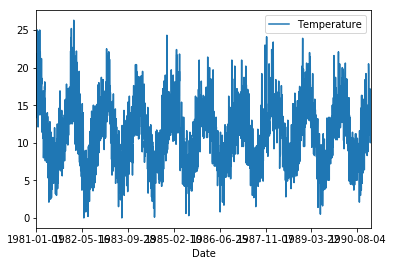

In [104]:
df.plot()

#### Descibe your dataframe

In [105]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [110]:
print(df.isnull().any(axis=1).sum())

0


#### Drop null values

In [113]:
df.dropna(inplace=True)
df.isnull().sum()

Temperature    0
dtype: int64

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4eeca26898>]],
      dtype=object)

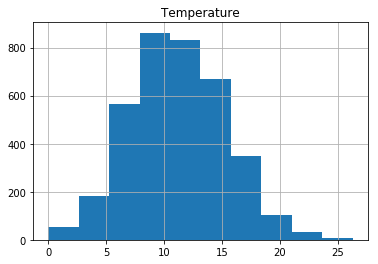

In [114]:
df.hist()

#### Check the maximum and minimum values

In [115]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [119]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [120]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [123]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [138]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
1095 1


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [126]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Summarize your model

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [132]:
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
2553/2553 [==============================] - 8s 3ms/step - loss: 0.0168
Epoch 2/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0142
Epoch 3/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0121
Epoch 4/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0112
Epoch 5/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0107
Epoch 6/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0104
Epoch 7/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0104
Epoch 8/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0104
Epoch 9/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0103
Epoch 10/10
2553/2553 [==============================] - 5s 2ms/step - loss: 0.0103


## Make Predictions and Evaluate your model

In [133]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.57 RMSE
Test Score: 2.41 RMSE


## Plot the results

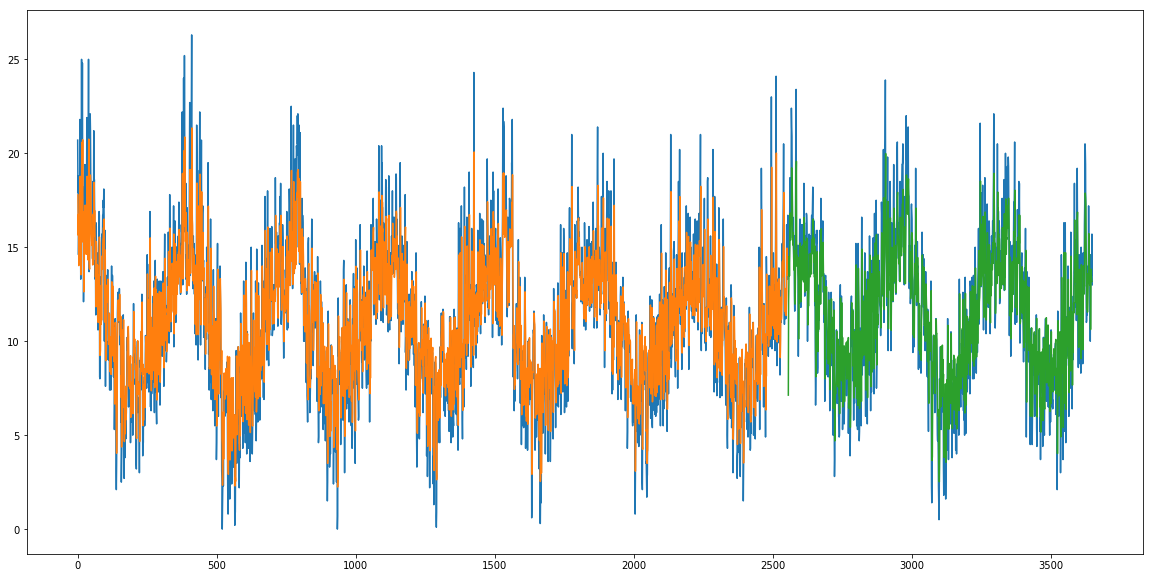

In [136]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()